In [1]:
import pandas as pd
from pathlib import Path 

In [2]:
tables_path = Path('data', 'tables')
df = pd.read_csv(tables_path / 'merged_award_show_winners.csv', keep_default_na=False, na_values=[''])
df.head()

,Show,Date,Artist,Song,Total,Placement,file_path,vggish_dance,vggish_party,vggish_happy,vggish_sad,effnet_party,effnet_happy,effnet_sad,effnet_approachability,effnet_engagement,effnet_timbre_bright,tempo
0,Music Bank,2022-01-07,NCT U,Universe (Let's Play Ball),5930,1,data/audio/universe_(let's_play_ball)_nct_u.flac,90.834355,24.404429,69.484723,76.007283,1.950100,47.702590,92.827344,84.677964,96.713340,50.498027,90.0
1,Show! Music Core,2022-01-08,IVE,ELEVEN,6408,1,data/audio/eleven_ive.flac,94.969481,14.487433,81.253177,86.618626,2.623723,44.954056,88.753748,91.413623,92.127520,51.922780,120.0
2,Inkigayo,2022-01-09,IVE,ELEVEN,8533,1,data/audio/eleven_ive.flac,94.969481,14.487433,81.253177,86.618626,2.623723,44.954056,88.753748,91.413623,92.127520,51.922780,120.0
3,M Countdown,2022-01-13,Kep1er,WA DA DA,6500,1,data/audio/wa_da_da_kep1er.flac,96.806103,8.892013,78.541768,93.300325,1.427681,66.826451,95.882249,71.226579,97.789687,49.050614,126.0
4,Music Bank,2022-01-14,Kep1er,WA DA DA,3678,1,data/audio/wa_da_da_kep1er.flac,96.806103,8.892013,78.541768,93.300325,1.427681,66.826451,95.882249,71.226579,97.789687,49.050614,126.0


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Winner'] = (df.Placement == 1).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Show                    1710 non-null   object        
 1   Date                    1710 non-null   datetime64[ns]
 2   Artist                  1710 non-null   object        
 3   Song                    1710 non-null   object        
 4   Total                   1710 non-null   int64         
 5   Placement               1710 non-null   int64         
 6   file_path               1710 non-null   object        
 7   vggish_dance            1710 non-null   float64       
 8   vggish_party            1710 non-null   float64       
 9   vggish_happy            1710 non-null   float64       
 10  vggish_sad              1710 non-null   float64       
 11  effnet_party            1710 non-null   float64       
 12  effnet_happy            1710 non-null   float64 

### Minor Processing

I noticed that there were some inconsistencies with the naming conventions for the artist column, so I going back to match any artist that conflict with their winning artist naming convention (if that artist has won before, otherwise do not change)

In [4]:
# import pandas as pd
# from thefuzz import process, fuzz

# def fuzzy_match_artists(non_winners, df_full, artist_col="Artist", score_cutoff=85):
#     full_artist_list = df_full[artist_col].dropna().unique().tolist()
#     results = []

#     for artist in non_winners:
#         match_result = process.extractOne(artist, full_artist_list, score_cutoff=score_cutoff)

#         if match_result is not None:
#             match, score = match_result
#             results.append({
#                 "original_artist": artist,
#                 "matched_artist": match,
#                 "match_score": score
#             })
#         else:
#             results.append({
#                 "original_artist": artist,
#                 "matched_artist": None,
#                 "match_score": None
#             })

#     return pd.DataFrame(results)



# def correct_song_titles(df, artist_col='Artist', song_col='Song', correct_df=None, score_cutoff=92):

#     corrected_titles = []

#     for artist in df[artist_col].unique():
#         songs_to_check = df[df[artist_col] == artist][song_col].unique()
#         correct_songs = correct_df[correct_df[artist_col] == artist][song_col].unique()

#         for song in songs_to_check:
#             match = process.extractOne(song, correct_songs, scorer=fuzz.token_sort_ratio, score_cutoff=score_cutoff)
#             if match:
#                 corrected_titles.append((artist, song, match[0]))
#             else:
#                 corrected_titles.append((artist, song, song))  # fallback to original

#     # Create mapping and apply it
#     correction_map = {(a, s): c for a, s, c in corrected_titles}
#     df[f'{song_col}_corrected'] = df.apply(lambda row: correction_map.get((row[artist_col], row[song_col]), row[song_col]), axis=1)

#     return df

In [5]:
# most_wins = df.groupby('Artist')['Winner'].sum().sort_values(ascending=False)

# non_winners = most_wins[most_wins.values == 0].keys().tolist()
# winners = df.copy()[~df.Artist.isin(non_winners)]

# matches = fuzzy_match_artists(non_winners, winners, score_cutoff=92)
# match_dict = dict(zip(matches['original_artist'], matches['matched_artist']))

# display(matches[~matches['match_score'].isna()].sort_values(by=['match_score', 'original_artist'], ascending=[False, True]))

In [6]:
# df['Artist'] = df['Artist'].map(match_dict).combine_first(df["Artist"])

<!-- There were two inconsistencies that weren't corrected via fuzzy matching: Hwang Karam's name was misspelled as Hwang Kagam and (G)I-dle's name wasn't made consistent. -->

## Initial Inspections

In this section, I want to explore some basic insights found within the data such as what group has the most wins, who is always on the cusp of achieving their first win, and the trends within the total amount of votes observed within certain time periods. Most of this analysis will likely pertain to the first 6 columns: `Show`, `Date`, `Artist`, `Song`, `Total`, and `Winner`

In [7]:
most_wins = df[df.Placement == 1].groupby('Artist')['Placement'].sum().sort_values(ascending=False)
display(most_wins[:10])

Artist
IVE            64
(G)I-DLE       42
NewJeans       35
LE SSERAFIM    34
aespa          28
SEVENTEEN      26
STRAY KIDS     26
NCT DREAM      23
ATEEZ          19
Jung Kook      18
Name: Placement, dtype: int64

In [8]:
never_won_filter = (df.Placement != 1) & (~df.Artist.isin(most_wins.keys()))
never_won = df.loc[never_won_filter] \
    .groupby('Artist')['Placement'] \
    .count() \
    .sort_values(ascending=False)

So far, we have a great understanding of which artists are highly decorated in music show wins and artists that have yet achieved their coveted win. In terms of artists with the most wins, there are no surprises as this list is dominated by the most popular 4th generation BGs and GGs. For artists that haven't won, we can observe several 5th generation groups such as YOUNG POSSE, RESCENE, MEOWV whom are barely starting their careers in KPOP so there is definitely potential for them to find a win within the coming years. Additionally, we can observe that it's a bit of a struggle for solo artists to obtain a win. With the exception of ROSÉ because she won with APT with Bruno Mars, winning at a music show can be difficult despite an idol's popularity. For example, veterans such as Wendy, Lee Chae-yeon, and Tzuyu are well-known female idols that come from very popular groups (Red Velvet, ex-Izone, Twice respectively) but haven't been able to acquire awards. Next, I want to observe music show wins on a monthly basis

In [9]:
columns_to_drop = ['file_path', 'vggish_dance', 'vggish_party', 'vggish_happy', 'vggish_sad', 'effnet_party', 
                   'effnet_happy', 'effnet_sad', 'effnet_approachability', 'effnet_engagement', 'effnet_timbre_bright', 'tempo']

# Track the cumulative wins for a given group
df_stats = df.copy().sort_values(by='Date').reset_index(drop=True)
df_stats = df_stats.drop(columns=columns_to_drop)

df_stats['cumulative_wins'] = df_stats.groupby('Artist')['Winner'].cumsum()

df_stats.tail(10)

,Show,Date,Artist,Song,Total,Placement,Winner,cumulative_wins
1700,M Countdown,2025-04-10,LE SSERAFIM,HOT,4930,2,0,33
1701,Music Bank,2025-04-11,CLOSE YOUR EYES,All My Poetry,5507,1,1,2
1702,Show! Music Core,2025-04-12,JENNIE,like JENNIE,6095,1,1,7
1703,The Show,2025-04-15,izna,Sign,8450,1,1,1
1704,Show Champion,2025-04-16,Mark,1999,5592,1,1,1
1705,M Countdown,2025-04-17,J-Hope,MONA LISA,7643,1,1,4
1706,Music Bank,2025-04-18,Mark,1999,9606,1,1,2
1707,Show! Music Core,2025-04-19,Mark,1999,7159,1,1,3
1708,Inkigayo,2025-04-20,LE SSERAFIM,HOT,4556,1,1,34
1709,Show Champion,2025-04-23,UNIS,Swicy,6467,1,1,1


In [10]:
most_wins[:15]

Artist
IVE            64
(G)I-DLE       42
NewJeans       35
LE SSERAFIM    34
aespa          28
SEVENTEEN      26
STRAY KIDS     26
NCT DREAM      23
ATEEZ          19
Jung Kook      18
STAYC          18
BLACKPINK      17
G-Dragon       16
ZEROBASEONE    15
THE BOYZ       15
Name: Placement, dtype: int64

In [11]:
# Gather the top 5 Artists relative to wins
top_5 = df_stats.loc[df_stats.Artist.isin(most_wins.keys()[:5])]
top_5_artists = top_5.Artist.unique()
top_5_wins = top_5.loc[top_5.Placement == 1]
first_wins = top_5_wins.groupby(['Artist', 'Song'])['Date'].min().to_dict()

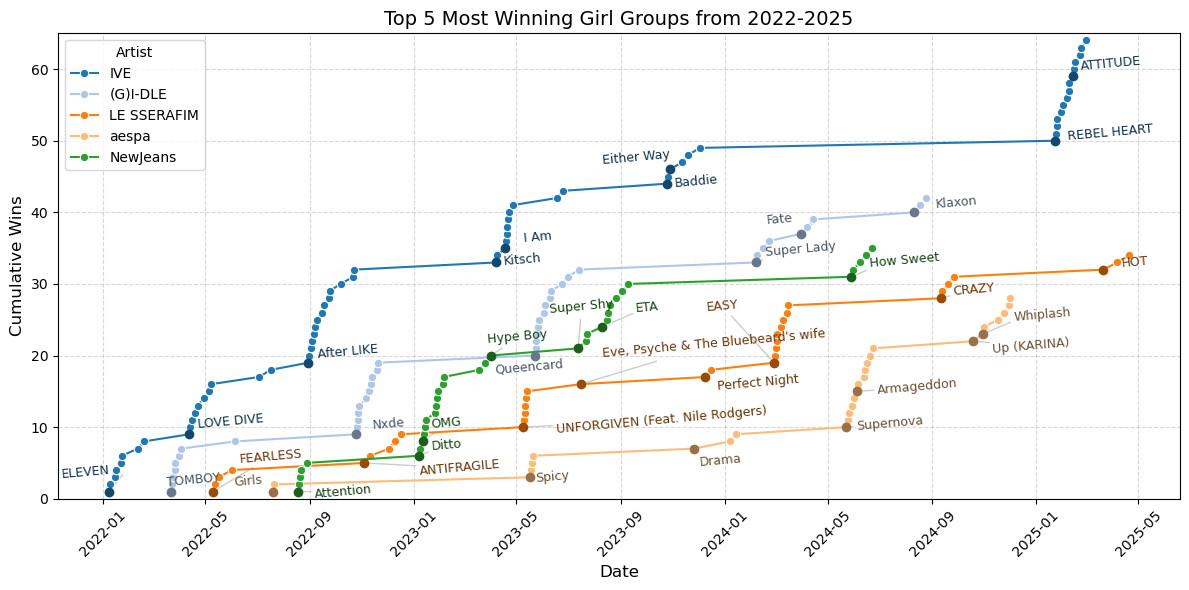

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function for darkening scatter points and text
def darken(color, factor=0.6):
    return tuple([max(0, min(1, c*factor)) for c in color])

plt.figure(figsize=(12, 6))
palette = sns.color_palette('tab20', n_colors=5)
artist_colors = dict(zip(top_5_artists, palette))

sns.lineplot(data=top_5_wins, x='Date', y='cumulative_wins', hue='Artist', marker='o', palette=artist_colors)

# Place the text and point to denote a song's first win
texts = []
for (artist, song), win_date in first_wins.items():
    song_data = top_5_wins[(top_5_wins['Artist'] == artist) & (top_5_wins['Date'] == win_date)]
    win_score = song_data['cumulative_wins'].values[0]
    song = song_data['Song'].values[0]
    darker_color = darken(artist_colors[artist], 0.6)

    plt.scatter(win_date, win_score, color=darker_color, zorder=5)
    texts.append(plt.text(win_date, win_score, f'{song}', fontsize=9, rotation=5.1, color=darken(darker_color, .7), zorder=6))

# Make automatic adjustments
adjust_text(texts, only_move={'text': 'xy'}, 
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
            )

# Manual Text Adjustments
for text in texts:
    if text.get_text() in ['ELEVEN', 'Girls', 'Fate']:
        text.set_position((text.get_position()[0] - (pd.Timedelta(days=45)/pd.Timedelta(days=1)), text.get_position()[1]))
    elif text.get_text() in 'Either Way':
        text.set_position((text.get_position()[0] - (pd.Timedelta(days=90)/pd.Timedelta(days=1)), text.get_position()[1]))
    elif text.get_text() in ['HOT', 'I Am', 'Whiplash', 'Queencard', 'How Sweet', 'Klaxon', 'Super Lady', 'Nxde']:
        text.set_position((text.get_position()[0] + (pd.Timedelta(days=16)/pd.Timedelta(days=1)), text.get_position()[1]))


plt.xticks(rotation=45)
plt.ylim(0, max(top_5_wins.cumulative_wins + 1))

plt.title('Top 5 Most Winning Girl Groups from 2022-2025', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Wins', fontsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [13]:
df_song = df_stats.copy()
df_song['cumulative_song_wins'] = df_song.groupby(['Artist', 'Song'])['Winner'].cumsum()
df_song.tail(10)

,Show,Date,Artist,Song,Total,Placement,Winner,cumulative_wins,cumulative_song_wins
1700,M Countdown,2025-04-10,LE SSERAFIM,HOT,4930,2,0,33,2
1701,Music Bank,2025-04-11,CLOSE YOUR EYES,All My Poetry,5507,1,1,2,2
1702,Show! Music Core,2025-04-12,JENNIE,like JENNIE,6095,1,1,7,5
1703,The Show,2025-04-15,izna,Sign,8450,1,1,1,1
1704,Show Champion,2025-04-16,Mark,1999,5592,1,1,1,1
1705,M Countdown,2025-04-17,J-Hope,MONA LISA,7643,1,1,4,2
1706,Music Bank,2025-04-18,Mark,1999,9606,1,1,2,2
1707,Show! Music Core,2025-04-19,Mark,1999,7159,1,1,3,3
1708,Inkigayo,2025-04-20,LE SSERAFIM,HOT,4556,1,1,34,3
1709,Show Champion,2025-04-23,UNIS,Swicy,6467,1,1,1,1


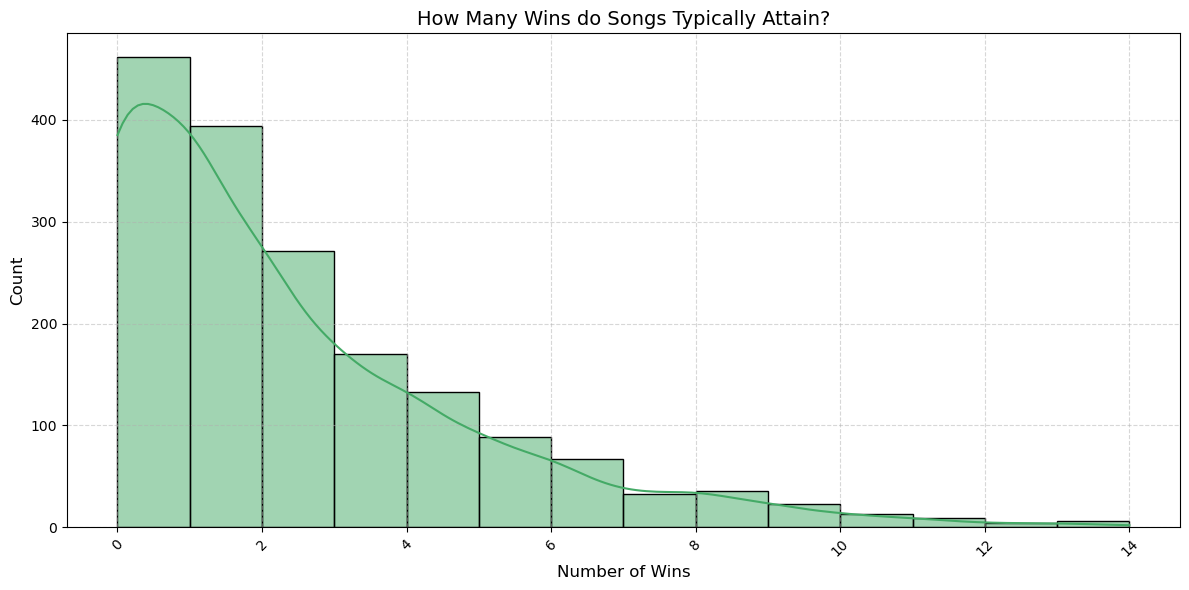

In [14]:
plt.figure(figsize=(12,6))

sns.histplot(data=df_song, x="cumulative_song_wins", stat='count', binwidth=1, kde=True, color="#44AA66")

plt.xticks(rotation=45)

plt.title("How Many Wins do Songs Typically Attain?", fontsize=14)
plt.xlabel("Number of Wins", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
artists_per_winning = df.groupby('Artist').agg(
    total_wins=('Winner', 'sum'),
    total_appearances=('Date', 'count'),
    total_songs=('Song', 'nunique')
)

artists_per_winning['win_ratio'] = artists_per_winning['total_wins'] / artists_per_winning['total_appearances']
artists_per_winning['avg_wins_per_song'] = artists_per_winning['total_wins'] / artists_per_winning['total_songs']
artists_per_winning

,total_wins,total_appearances,total_songs,win_ratio,avg_wins_per_song
Artist,,,,,
(G)I-DLE,42,70,7,0.600000,6.0
82MAJOR,0,1,1,0.000000,0.0
8TURN,0,2,2,0.000000,0.0
A.C.E,0,1,1,0.000000,0.0
AB6IX,1,2,2,0.500000,0.5
...,...,...,...,...,...
fromis_9,12,17,4,0.705882,3.0
izna,1,3,2,0.333333,0.5
n.SSign,1,8,5,0.125000,0.2


In [16]:
artists_per_winning.sort_values(['win_ratio', 'avg_wins_per_song'], ascending=False).head(10)

,total_wins,total_appearances,total_songs,win_ratio,avg_wins_per_song
Artist,,,,,
BIGBANG,9,9,1,1.0,9.0
BLACKPINK,17,17,2,1.0,8.5
PSY,7,7,1,1.0,7.0
ASTRO,4,4,1,1.0,4.0
GOT the beat,3,3,1,1.0,3.0
Mark,3,3,1,1.0,3.0
BtoB,2,2,1,1.0,2.0
Kai,2,2,1,1.0,2.0
LOONA,2,2,1,1.0,2.0


In [17]:
def wins_within_date_range(df, show='all', date_start='2022-01-01', date_end='3005-01-01'):
    date_range_filter = (df.Date >= date_start) & (df.Date <= date_end)

    # Determine show filter
    if show == 'all':
        show_filter = True
    elif show in df['Show'].unique():
        show_filter = (df['Show'] == show)
    else:
        print(f"Warning: '{show}' is not a recognized show. Returning empty result.\nValid shows are: {df.Show.unique().tolist()}")
        return pd.DataFrame(columns=[
            'total_wins', 'total_appearances', 'total_comebacks',
            'win_ratio', 'avg_wins_per_comeback'
        ])
    
    artists_per_winning = df[(date_range_filter) & (show_filter)].groupby('Artist').agg(
        total_wins=('Winner', 'sum'),
        total_appearances=('Date', 'count'),
        total_comebacks=('Song', 'nunique')
    )

    artists_per_winning['win_ratio'] = artists_per_winning['total_wins'] / artists_per_winning['total_appearances']
    artists_per_winning['avg_wins_per_comeback'] = artists_per_winning['total_wins'] / artists_per_winning['total_comebacks']
    return artists_per_winning.sort_values(['win_ratio', 'avg_wins_per_comeback'], ascending=False)

In [20]:
wins_within_date_range(df, date_start='2025-01-01', date_end='2025-04-24', show="Music Bank").head(10)

,total_wins,total_appearances,total_comebacks,win_ratio,avg_wins_per_comeback
Artist,,,,,
BSS,1,1,1,1.0,1.0
CLOSE YOUR EYES,1,1,1,1.0,1.0
EVNNE,1,1,1,1.0,1.0
Eunhyuk,1,1,1,1.0,1.0
LE SSERAFIM,1,1,1,1.0,1.0
MINNIE,1,1,1,1.0,1.0
Mark,1,1,1,1.0,1.0
NMIXX,1,1,1,1.0,1.0
ONF,1,1,1,1.0,1.0
